<a href="https://colab.research.google.com/github/Lucas-Armand/-DESAFIO-API---Infra-GLOBOPLAY-/blob/master/An%C3%A1lise_Resili%C3%AAncia_da_Rede_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análise Resiliência da Rede

Nesse trabalho iremos realizar uma análise da resiliência de um rede simulando de falhas na camada dos links físico e calculando o impacto sobre os links lógicos. Algoritmo de análise de resiliência da rede baseado em múltiplas simulações do escoamento das demandas da rede, limitadas pelas capacidades dos links, minimizando o número de links até o destino. As métricas do impactos das falhas devem ser avaliadas no nível dos links lógico e considerar as probabilidades das falhas (sejam elas simples, duplas, etc).

---
### Ferramentas utilizadas
O trabalho foi baseado na biblioteca networkx e utiliza a o método "min_cost_flow_cost" para as simulações do escoamento.

In [0]:
import networkx as nx
import matplotlib.pyplot as plt

### Construção da rede exemplo

Com o intuito de validar o método proposto, uma rede exemplo foi construida. Para melhor análise a rede será exebida em dois níveis de visulização: O nível dos links lógicos e o nível dos links físicos:

In [0]:
# Rede nivel link lógico:
g = nx.DiGraph()
g.add_node('A', demand = -150)
g.add_node('B', demand = -150)
g.add_node('C', demand = -150)
g.add_node('D', demand = 450)
g.add_edge('A', 'B')
g.add_edge('A', 'C')
g.add_edge('B', 'C')
g.add_edge('C', 'B')
g.add_edge('B', 'D')
g.add_edge('C', 'D')


# Rede nivel link físico:
G = nx.DiGraph()
G.add_node('A', demand = -150)
G.add_node('B', demand = -150)
G.add_node('C', demand = -150)
G.add_node('D', demand = 450)
G.add_edge('A', 'a', weight = 1, capacity = 100)
G.add_edge('A', 'b', weight = 1, capacity = 100)
G.add_edge('A', 'c', weight = 1, capacity = 100)
G.add_edge('A', 'd', weight = 1, capacity = 200)
G.add_edge('a', 'B', weight = 1, capacity = 100)
G.add_edge('b', 'B', weight = 1, capacity = 100)
G.add_edge('c', 'B', weight = 1, capacity = 50)
G.add_edge('c', 'C', weight = 1, capacity = 50)
G.add_edge('d', 'C', weight = 1, capacity = 200)
G.add_edge('C', 'B', weight = 1, capacity = 100)
G.add_edge('B', 'C', weight = 1, capacity = 100)
G.add_edge('B', 'f', weight = 1, capacity = 100)
G.add_edge('B', 'g', weight = 1, capacity = 100)
G.add_edge('B', 'h', weight = 1, capacity = 100)
G.add_edge('C', 'i', weight = 1, capacity = 100)
G.add_edge('C', 'j', weight = 1, capacity = 100)
G.add_edge('C', 'k', weight = 1, capacity = 100)
G.add_edge('f', 'D', weight = 1, capacity = 100)
G.add_edge('g', 'D', weight = 1, capacity = 100)
G.add_edge('h', 'l', weight = 1, capacity = 100)
G.add_edge('l', 'D', weight = 1, capacity = 100)
G.add_edge('i', 'D', weight = 1, capacity = 100)
G.add_edge('j', 'D', weight = 1, capacity = 100)
G.add_edge('k', 'D', weight = 1, capacity = 100)


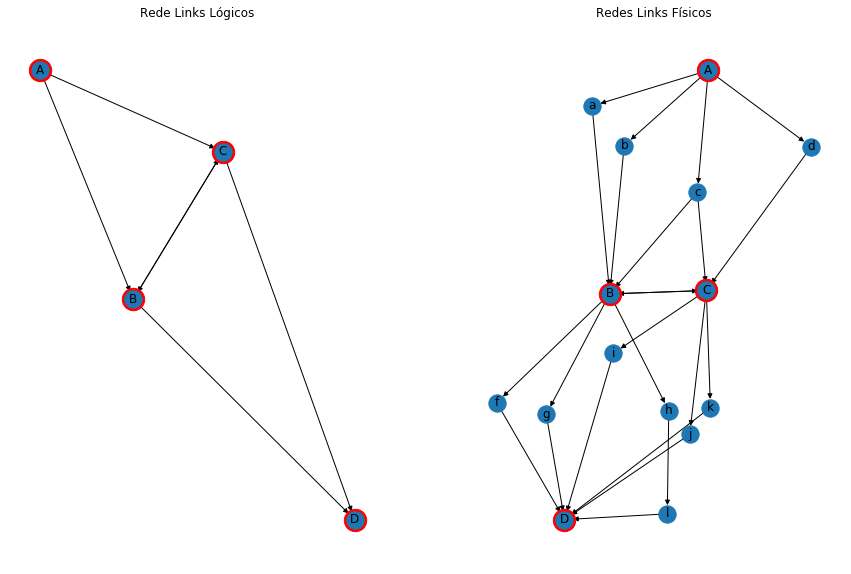

In [0]:
# Construindo a visualização das redes:

plt.figure(figsize=(15,10))

plt.subplot(121)
plt.title("Rede Links Lógicos")

pos=nx.kamada_kawai_layout(g) 
pos=nx.spring_layout(g) 
nx.draw_networkx_nodes(g,pos,nodelist=["A","B","C","D"],node_color='r',node_size=500)
nx.draw(g,pos,with_labels=True)


plt.subplot(122),
plt.title("Redes Links Físicos")

pos=nx.kamada_kawai_layout(G) 
pos=nx.spring_layout(G,pos=pos,iterations=40) 
nx.draw_networkx_nodes(G,pos,nodelist=["A","B","C","D"],node_color='r',node_size=500)
nx.draw(G,pos,with_labels=True)

plt.show()


A imagem a seguir é das mesmas representações da rede, com a adição de algumas anotações. Os valores em amarelo representam a capacidade de cada link. Os valores em azuis associados aos nós A, B e C são a quantidade de carga que precisa ser escoada até o nó D. Os agrupamentos na rede de links físicos (linhas pretas tracejadas) apresentam a relação de nós físicos associados a cada link lógico.


![image.png](attachment:image.png)

### Resultados do escoamento

Como já foi discutido anteriormente, para os cálculos de escoamento utilizaremos como base a rede dos links físicos (G) aplicando a função "min_cost_flow" da biblioteca "networkx". Um problema que deve ser explorado é como transpor os resultados da rede para a outra. Para isso defini um mapa que liga os trechos da rede física a rede lógica para gerar métricas.

Além disso, para facilitar a implementação, construí uma função que relaciona a demanda em cada link físico com a demanda total nos links lógicos.

In [0]:
mapPhysicalLinks2LogicalLinks = {'aB' : 1,'bB' : 1,'cB' : 1,'cC' : 2,'dC' : 2,'CB' : 3,'BC' : 3,'fD' : 4,'gD' : 4,'lD' : 4,'iD' : 5,'jD' : 5,'kD' : 5}

In [0]:
def demandaLogicalLink(mapPhysicalLinks2LogicalLinks,demandaPhysicalLinks):
    # Acessando todos os links lógicos
    LogicalLinks =  mapPhysicalLinks2LogicalLinks.values()
    
    # Construindo um dicionario para guardar o somatorio de toda a demanda em cada link logico 
    demandaLogicalLinks = {ll:0 for ll in LogicalLinks}
    
    # A partir das chaves "demandaPhysicalLinks" eu encontro o primeiro nó do link físico
    startPoints = demandaPhysicalLinks.keys()
    for startPoint in startPoints:
        # Usando o primeiro ponto do link físico eu acesso um dicionario com todos os pontos do grafo a partir desse ponto
        # e quanta demanda existe pra esse ponto:
        endPointsDict = demandaPhysicalLinks[startPoint]
        
        # A partir das chaves desse novo ponto eu posso encontrar o ponto final de cada link partindo do ponto inicial
        endPoints = endPointsDict.keys()
        for endPoint in endPoints:
            # Usando as chaves eu posso acessar a demanda em cada Lógical Link
            demand = endPointsDict[endPoint]

            if demand > 0: # Se a demanda for maior que zero eu adicionoa ao somatório:
                physicalLink = startPoint+endPoint
                
                # Garantindo que esse link físico é relativo á um link lógico de interesse
                if physicalLink in mapPhysicalLinks2LogicalLinks.keys():
                    logicalLink = mapPhysicalLinks2LogicalLinks[physicalLink]
                    demandaLogicalLinks[logicalLink] += demand
                
    return demandaLogicalLinks
            
            

Dessa maneira podemos simular a demanda segundo os parâmetros para a rede de links físicos:

In [0]:
demandaPhysicalLinks = nx.min_cost_flow(G)
print(demandaPhysicalLinks)

{'A': {'a': 50, 'b': 0, 'c': 0, 'd': 100}, 'B': {'C': 0, 'f': 100, 'g': 100, 'h': 0}, 'C': {'B': 0, 'i': 100, 'j': 100, 'k': 50}, 'D': {}, 'a': {'B': 50}, 'b': {'B': 0}, 'c': {'B': 0, 'C': 0}, 'd': {'C': 100}, 'f': {'D': 100}, 'g': {'D': 100}, 'h': {'l': 0}, 'i': {'D': 100}, 'j': {'D': 100}, 'k': {'D': 50}, 'l': {'D': 0}}


E calcular a demanda para os links lógicos

In [0]:

demandaLogicalLink(mapPhysicalLinks2LogicalLinks,demandaPhysicalLinks)

{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}

Esse resultado representa o estado inicial do escoamento dessa rede de exemplo. A figura a seguir ilustra esse escoamento na rede:

![image.png](attachment:image.png)

---
## Simulação de um caso de falha na rede

Nesse ponto temos interesse de ver o impacto na rede de uma falha em um link físico. Para esse exemplo vamos desligar o link entre o nó "C" e o nó "k".


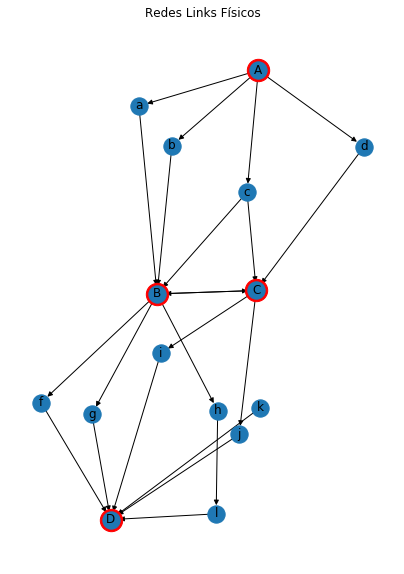

In [0]:
# Removendo o link entre "h" de "l"
G.remove_edge(*("C","k"))


# Construção da imagem
plt.figure(figsize=(7,10))
plt.title("Redes Links Físicos")
nx.draw_networkx_nodes(G,pos,nodelist=["A","B","C","D"],node_color='r',node_size=500)
nx.draw(G,pos,with_labels=True)

plt.show()

De maneira análoga ao anteriormente discutido temos:

In [0]:
demandaPhysicalLinks = nx.min_cost_flow(G)
demandaLogicalLink(mapPhysicalLinks2LogicalLinks,demandaPhysicalLinks)

{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}

Nesse caso a rede inverter o fluxo de demanda, em vez de mandar a maior demanda pelos links lógicos 2 e 5, a solução escolhida foi dar preferência aos links 1 e 4, uma vez que falha diminui a capacidade de escolamento do nó 5.
![image.png](attachment:image.png)



---
## Simulação de múltiplas falhas

Nesse ponto seria interessante explorar o efeito das diversas possibilidades de falhas que podem ocorrer na rede. A seguir os resultados para falhas simples e duplas. Associar esses resultados as probabilidades das falhas seria o próximo passo da análise.

In [0]:
edges = G.edges
edgesData = G.edges.data()


print("Iniciando Simulação de Falha Simples na Rede:")
for edgeData in edgesData:
    G.remove_edge(*(edgeData[0],edgeData[1]))
    try :
        print(demandaLogicalLink(mapPhysicalLinks2LogicalLinks,nx.min_cost_flow(G)))
    except:
        print('Unsolvable network!')
    G.add_edge(edgeData[0],edgeData[1],weight = edgeData[2]['weight'], capacity = edgeData[2]['capacity'])

print("Finalizando Simulação de Falha Simples na Rede:")
print("")


Iniciando Simulação de Falha Simples na Rede:
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 0, 2: 150, 3: 0, 4: 150, 5: 300}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 0, 2: 150, 3: 0, 4: 150, 5: 300}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 0, 2: 150, 3: 0, 4: 150, 5: 300}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 0, 2: 150, 3: 0, 4: 150, 5: 300}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 100,

In [0]:
print("Iniciando Simulação de Falhas Duplas na Rede:")
for edgeData1 in edgesData:
    for edgeData2 in edgesData:
        if edgeData1 != edgeData2:
            G.remove_edge(*(edgeData1[0],edgeData1[1]))
            G.remove_edge(*(edgeData2[0],edgeData2[1]))
            try :
                print(demandaLogicalLink(mapPhysicalLinks2LogicalLinks,nx.min_cost_flow(G)))
            except:
                print("***")
                print(edgeData1)
                print(edgeData2)
                print('Unsolvable network!')
                print("***")

            G.add_edge(edgeData1[0],edgeData1[1],weight = edgeData1[2]['weight'], capacity = edgeData1[2]['capacity'])
            G.add_edge(edgeData2[0],edgeData2[1],weight = edgeData2[2]['weight'], capacity = edgeData2[2]['capacity'])

print("Finalizando Simulação de Falhas Duplas na Rede:")
print("")


Iniciando Simulação de Falhas Duplas na Rede:
{1: 150, 2: 0, 3: 0, 4: 300, 5: 150}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 150, 2: 0, 3: 0, 4: 300, 5: 150}
{1: 0, 2: 150, 3: 0, 4: 150, 5: 300}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 0, 2: 150, 3: 0, 4: 150, 5: 300}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 0, 2: 150, 3: 0, 4: 150, 5: 300}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 0, 2: 150, 3: 0, 4: 150, 5: 300}
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2:

Unsolvable network!
***
***
('C', 'j', {'weight': 1, 'capacity': 100})
('k', 'D', {'weight': 1, 'capacity': 100})
Unsolvable network!
***
***
('C', 'j', {'weight': 1, 'capacity': 100})
('k', 'D', {'weight': 1, 'capacity': 100})
Unsolvable network!
***
***
('C', 'j', {'weight': 1, 'capacity': 100})
('l', 'D', {'weight': 1, 'capacity': 100})
Unsolvable network!
***
***
('C', 'j', {'weight': 1, 'capacity': 100})
('l', 'D', {'weight': 1, 'capacity': 100})
Unsolvable network!
***
***
('C', 'j', {'weight': 1, 'capacity': 100})
('l', 'D', {'weight': 1, 'capacity': 100})
Unsolvable network!
***
***
('C', 'j', {'weight': 1, 'capacity': 100})
('l', 'D', {'weight': 1, 'capacity': 100})
Unsolvable network!
***
***
('C', 'j', {'weight': 1, 'capacity': 100})
('l', 'D', {'weight': 1, 'capacity': 100})
Unsolvable network!
***
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 100, 2: 50, 3: 0, 4: 2

{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 50, 2: 100, 3: 0, 4: 200, 5: 250}
{1: 100, 2: 50, 3: 50, 4: 200, 5: 250}
{1: 100, 2: 50, 3: 50, 4: 200, 5: 250}
{1: 100, 2: 50, 3: 50, 4: 200, 5: 250}
{1: 150, 2: 0, 3: 100, 4: 200, 5: 250}
{1: 100, 2: 50, 3: 50, 4: 200, 5: 250}
{1: 100, 2: 50, 3: 50, 4: 200, 5: 250}
{1: 100, 2: 50, 3: 50, 4: 200, 5: 250}
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 100, 2: 50, 3: 50, 4: 200, 5: 250}
{1: 100, 2: 50, 3: 50, 4: 200, 5: 250}
{1: 100, 2: 50, 3: 50, 4: 200, 5: 250}
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 100, 2: 50, 3: 50, 4: 200, 5: 250}
{1: 100, 2: 50, 3: 50, 4: 200, 5: 250}
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}
{1: 100, 2: 50, 3: 0, 4: 250, 5: 200}


***
***
('j', 'D', {'weight': 1, 'capacity': 100})
('i', 'D', {'weight': 1, 'capacity': 100})
Unsolvable network!
***
***
('j', 'D', {'weight': 1, 'capacity': 100})
('i', 'D', {'weight': 1, 'capacity': 100})
Unsolvable network!
***
***
('j', 'D', {'weight': 1, 'capacity': 100})
('i', 'D', {'weight': 1, 'capacity': 100})
Unsolvable network!
***
***
('j', 'D', {'weight': 1, 'capacity': 100})
('i', 'D', {'weight': 1, 'capacity': 100})
Unsolvable network!
***
***
('j', 'D', {'weight': 1, 'capacity': 100})
('k', 'D', {'weight': 1, 'capacity': 100})
Unsolvable network!
***
***
('j', 'D', {'weight': 1, 'capacity': 100})
('k', 'D', {'weight': 1, 'capacity': 100})
Unsolvable network!
***
***
('j', 'D', {'weight': 1, 'capacity': 100})
('k', 'D', {'weight': 1, 'capacity': 100})
Unsolvable network!
***
***
('j', 'D', {'weight': 1, 'capacity': 100})
('k', 'D', {'weight': 1, 'capacity': 100})
Unsolvable network!
***
***
('j', 'D', {'weight': 1, 'capacity': 100})
('k', 'D', {'weight': 1, 'capacity': 